# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# fill in your code...
train_sent = pd.read_csv("data_sentiment/train.csv", header=None, names=["train", "label"])
valid_sent = pd.read_csv("data_sentiment/dev.csv", header=None, names=["valid", "label"])
test_sent = pd.read_csv("data_sentiment/test.csv", header=None, names=["test", "label"])

If you use Pandas you can see a sample of the data.

In [3]:
train_sent.head()

valid_sent.head()

,valid,label
0,"if he doesn=92t watch out , mel gibson is in d...",1
1,"wong kar-wei's "" fallen angels "" is , on a pur...",1
2,there is nothing like american history x in th...,1
3,"an unhappy italian housewife , a lonely waiter...",1
4,"when people are talking about good old times ,...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# fill in your code...
train_sent_list = list(train_sent.loc[:, "train"])
train_sent_label_arr = np.array(train_sent.loc[:, "label"]).reshape(1, -1)

valid_sent_list = list(valid_sent.loc[:, "valid"])
valid_sent_label_arr = np.array(valid_sent.loc[:, "label"]).reshape(1, -1)

test_sent_list = list(test_sent.loc[:, "test"])
test_sent_label_arr = np.array(test_sent.loc[:, "label"])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    # fill in your code...
    pattern = re.compile(token_pattern)
    x= []
    # 1. tokenise all texts into a list of unigrams.
    x_raw = pattern.findall(x_raw.lower())

    # 2. remove stop words.
    x_new = [i for i in x_raw if i not in stop_words]
    len_x_new = len(x_new)
    
    # 3. compute ngram.
    for n in range(ngram_range[0]+1, ngram_range[1]+1): 
        for i in range(len_x_new-n+1):
            x_new.append(tuple(x_new[i:i+n]))
    
    # 4. create a vocabulary(list) of uni, bi, tri.
    for i in x_new:
        if len(vocab) != 0:
            if i in vocab:
                x.append(i)
        else:
            x.append(i)
        
    return x

In [7]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [8]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great', ('great','movie')]) )

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    # fill in your code...
    df, ngram_counts = dict(), dict()
    
    for l in X_raw:
        doc_list = extract_ngrams(l, ngram_range, token_pattern, stop_words, set()) 
        # key and counts have the same keys.
        key = list(set(doc_list))
        counts = Counter(doc_list) 
        for k in key:
            # df.
            df[k] = (df[k]+1) if k in df else 1
            # tf.
            ngram_counts[k] = (ngram_counts[k]+counts[k]) if k in ngram_counts else counts[k]   
            
    # min_df.
    if min_df != 0:
        df_values = np.array(list(df.values())) # to array.
        df_values[df_values < min_df] = min_df
        df = dict(zip(df.keys(), df_values))
    
    # sort df and ngram_counts.
    df = Counter(dict(sorted(df.items(),key=lambda x:x[1], reverse=True)))
    ngram_counts = dict(sorted(ngram_counts.items(),key=lambda x:x[1], reverse=True))
    vocab = list(ngram_counts.keys()) # using tf.
    
    # Top n: update vocab, df and ngram_counts.
    if keep_topN != 0:
        # don't choose topN df.
        df = Counter(dict(zip(list(df.keys()), list(df.values()))))
        ngram_counts = dict(zip(list(ngram_counts.keys())[:keep_topN], list(ngram_counts.values())[:keep_topN]))
        # using topN tf as vocab.
        vocab = list(ngram_counts.keys())[:keep_topN]
        
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
# train_sent_df is not sorted and has the different order with features.
features, train_sent_df, _ = get_vocab(train_sent_list, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

print(len(features)) # from training set.

5000


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [11]:
# the dictionary will be created in vectorise(). see below.

Now you should be able to extract n-grams for each text in the training, development and test sets:

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [12]:
def vectorise(X_ngram, vocab):
    X_ngram_dict = dict()
    for i, l in enumerate(X_ngram):
        # create a dict that follows vocab order.
        X_ngram_dict[i] = dict(zip(vocab, len(vocab)*[0]))
        # extract features from doc.
        doc_ngrams = extract_ngrams(l, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab) 
        # update this dict by doc_ngrams.
        X_ngram_dict[i].update(dict(Counter(doc_ngrams).most_common()))
        
    # change X_ngram from dict to list.
    X_ngram_list = list()
    for k, v in X_ngram_dict.items():
        X_ngram_list.append(list(v.values()))    
    
    # change to array.
    X_vec = np.array(X_ngram_list)
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [13]:
# fill in your code...
vocab = set(features)
X_tr_tf = vectorise(train_sent_list, vocab)
X_val_tf = vectorise(valid_sent_list, vocab)
X_te_tf = vectorise(test_sent_list, vocab)

print(X_tr_tf.shape)
print(X_val_tf.shape)
print(X_te_tf.shape)

(1400, 5000)
(200, 5000)
(400, 5000)


#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [14]:
# df of training set keeps same order with vocab.
train_sent_df_order = dict(zip(vocab, len(vocab)*[0]))

for i in vocab:
    train_sent_df_order[i] = train_sent_df[i]
    
print(len(train_sent_df_order))

5000


In [15]:
# training df, idfs.
X_tr_df = np.array(list(train_sent_df_order.values()))
X_tr_idfs = np.log10(X_tr_tf.shape[0]/X_tr_df)

# valid df, idfs.
X_val_df = sum(X_val_tf != 0) + 1
X_val_idfs = np.log10(X_val_tf.shape[0]/X_val_df)

# testing df, idfs.
X_te_df = sum(X_te_tf != 0) + 1
X_te_idfs = np.log10(X_te_tf.shape[0]/X_te_df)

print(X_tr_idfs.shape)
print(X_val_idfs.shape)
print(X_te_idfs.shape)

(5000,)
(5000,)
(5000,)


Then transform your count vectors to tf.idf vectors:

In [16]:
# training tf.idf.
X_tr_tfidf = X_tr_tf*X_tr_idfs

# valid tf.idf.
X_val_tfidf = X_val_tf*X_val_idfs

# testing tf.idf.
X_te_tfidf = X_te_tf*X_te_idfs

print(X_tr_tfidf.shape)
print(X_val_tfidf.shape)
print(X_te_tfidf.shape)

(1400, 5000)
(200, 5000)
(400, 5000)


# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [17]:
def sigmoid(z):
    z = 1 / (1 + np.exp(-z)) 
    return z

In [18]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [19]:
def predict_proba(X, weights):
    preds_proba = sigmoid(np.dot(X, weights.T))
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [20]:
def predict_class(X, weights):
    
    # fill in your code...
    preds_class = (predict_proba(X, weights) > 0.5).astype(int)
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [21]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    # fill in your code...
    prob = predict_proba(X, weights) # (1, 1400)
    l = np.mean(-Y*np.log(prob) - (1 - Y)*np.log(1-prob)) + (weights**2).sum() / Y.shape[1]

    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [22]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, tolerance=0, epochs=5, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # weights and gradient of weights.
    w = np.zeros(X_tr.shape[1])
    
    # index of dataset for shuffle.
    X_tr_len = X_tr.shape[0]
    index = [i for i in range(X_tr_len)]
    
    for epo in range(1, epochs+1):
        # shuffle index.
        random.shuffle(index)
        for i in index:
            x_tr, y_tr = X_tr[i], Y_tr[0, i]
            gW = (predict_proba(x_tr, w) - y_tr)*x_tr  + 2*alpha*w
            w -= lr*gW
            
        # loss.
        tr_loss = binary_loss(X_tr, Y_tr, w, alpha)
        val_loss = binary_loss(X_dev, Y_dev, w, alpha)
        
        training_loss_history.append(tr_loss)
        validation_loss_history.append(val_loss)
        
        if print_progress == True:
            print("Epoch: ",epo, "| Training loss: ", tr_loss,"| Validation loss: ", val_loss)
            
        # the last 1 valid loss < last 2 valid loss && the difference between them < tolerance. 
        if epo >= 2:
            if  (tolerance != 0) & ((validation_loss_history[-2] - validation_loss_history[-1]) <= tolerance) & (validation_loss_history[-2] > validation_loss_history[-1]):
                print("stop training.")
                break;
    
    return w, training_loss_history, validation_loss_history

## task1.1 Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [23]:
# X_tr_tfidf = (1400, 5000); train_sent_label_arr = (1, 1400); w = (5000,)

w_count, loss_tr_count, dev_loss_count = SGD(X_tr_tf, train_sent_label_arr, 
                                             X_dev=X_val_tf, 
                                             Y_dev=valid_sent_label_arr, 
                                             lr=0.0001, 
                                             alpha=0.01, 
                                             tolerance=0.0001,
                                             epochs=100)

Epoch:  1 | Training loss:  0.628182700346381 | Validation loss:  0.6463229793929016
Epoch:  2 | Training loss:  0.5841374938885272 | Validation loss:  0.6161727621698808
Epoch:  3 | Training loss:  0.5513529118126342 | Validation loss:  0.5954022769727237
Epoch:  4 | Training loss:  0.5231557488290833 | Validation loss:  0.5751733456073743
Epoch:  5 | Training loss:  0.500692719743889 | Validation loss:  0.560427429659141
Epoch:  6 | Training loss:  0.48150814808641307 | Validation loss:  0.5482805646680041
Epoch:  7 | Training loss:  0.46478220404705595 | Validation loss:  0.5385129781925732
Epoch:  8 | Training loss:  0.4500614231746038 | Validation loss:  0.5298982291565775
Epoch:  9 | Training loss:  0.4369409903532592 | Validation loss:  0.5223618432284192
Epoch:  10 | Training loss:  0.4248456112195385 | Validation loss:  0.5141616479767984
Epoch:  11 | Training loss:  0.4140755927621455 | Validation loss:  0.508966578744997
Epoch:  12 | Training loss:  0.4059949086402756 | Vali

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

## task1.1.1 hyperparameter choose:

alpha: 0.0001
alpha: 0.001
alpha: 0.01
alpha: 0.1
alpha: 0.5


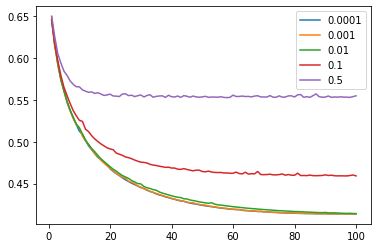

In [24]:
alpha = [0.0001, 0.001, 0.01, 0.1, 0.5]
dev_loss_count_list = list()

for a in alpha:
    print("alpha: "+str(a))
    _, _, dev_loss_count_1 = SGD(X_tr_tf, train_sent_label_arr, X_dev=X_val_tf, Y_dev=valid_sent_label_arr, lr=0.0001, alpha=a, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(5):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=alpha[i])
plt.legend()

learning rate: 5e-05
learning rate: 0.0001
learning rate: 0.001
learning rate: 0.005


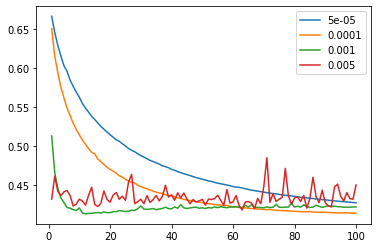

In [25]:
lr = [0.00005, 0.0001, 0.001, 0.005]
dev_loss_count_list = list()

for l in lr:
    print("learning rate: "+str(l))
    _, _, dev_loss_count_1 = SGD(X_tr_tf, train_sent_label_arr, X_dev=X_val_tf, Y_dev=valid_sent_label_arr, lr=l, alpha=0.01, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(4):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=lr[i])
plt.legend()

**According to the result above, learning rate and regularisation strength should be  0.0001 and 0.001 respectively.**

## task1.1.2 plot train and valid loss:

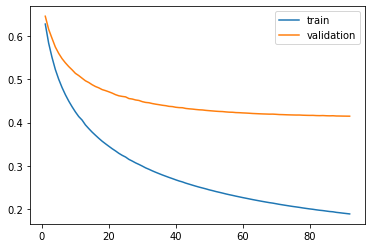

In [26]:
# loss_tr_count, dev_loss_count
epochs = [i for i in range(1, len(loss_tr_count)+1)]
plt.figure()
plt.plot(epochs, loss_tr_count, label="train")
plt.plot(epochs, dev_loss_count, label="validation")
plt.legend()

**Conclusion : the model is overfitting because the train loss is far smaller than validation loss. Moreover, the validation loss is stable after 20 epoch however, training loss is still decreasing.**

## task1.1.3 Compute accuracy, precision, recall and F1-scores:

In [27]:
# fill in your code...
preds_te_count = predict_class(X_te_tf, w_count)
Y_te = test_sent_label_arr

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8375
Precision: 0.8325123152709359
Recall: 0.845
F1-Score: 0.8387096774193549


## task1.1.4 Print the top-10 words for the negative and positive class respectively:

In [28]:
# positive.
dict_vocab_w = dict(zip(w_count, vocab))
dict_vocab_w_order = dict(sorted(dict_vocab_w.items(), key=lambda item: item[0], reverse=True))
print(list(dict_vocab_w_order.values())[:10])

['great', 'well', 'seen', 'fun', 'also', 'many', 'life', 'movies', 'both', 'world']


In [29]:
# negative.
print(list(dict_vocab_w_order.values())[-11:-1])

['supposed', 'nothing', 'any', 'plot', 'why', 'boring', 'worst', 'script', 'only', 'unfortunately']


**If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?**

Provide your answer here...

**those sentiment words, such as 'great', 'worst', might be useful in new domain because these words are very common to use when people express their emotion. In laptop review, for example, the review could be expressed as 'this laptop is great' or 'it is the worst'.**

## task1.2 Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [30]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, train_sent_label_arr, 
                         X_dev=X_val_tfidf, 
                         Y_dev=valid_sent_label_arr, 
                         lr=0.0001, 
                         alpha=0.001, 
                         tolerance=0.0001,
                         epochs=200)

Epoch:  1 | Training loss:  0.6388326166558195 | Validation loss:  0.6659941224189072
Epoch:  2 | Training loss:  0.597003531844976 | Validation loss:  0.6452233084393001
Epoch:  3 | Training loss:  0.5624917002857718 | Validation loss:  0.628021064764728
Epoch:  4 | Training loss:  0.5334677529991304 | Validation loss:  0.6131912195444543
Epoch:  5 | Training loss:  0.5082750536595131 | Validation loss:  0.600616648501783
Epoch:  6 | Training loss:  0.48636411944582036 | Validation loss:  0.5896196036728479
Epoch:  7 | Training loss:  0.4669325787791221 | Validation loss:  0.5797479463432231
Epoch:  8 | Training loss:  0.44956457978397907 | Validation loss:  0.5708960113663518
Epoch:  9 | Training loss:  0.4338652326332494 | Validation loss:  0.5629063509785364
Epoch:  10 | Training loss:  0.4195831153862801 | Validation loss:  0.5556723506387417
Epoch:  11 | Training loss:  0.40652600765824853 | Validation loss:  0.5490434058712494
Epoch:  12 | Training loss:  0.3944919644549594 | Va

Epoch:  95 | Training loss:  0.13621978261915357 | Validation loss:  0.4278162437753444
Epoch:  96 | Training loss:  0.1352813855339232 | Validation loss:  0.42759181419203846
Epoch:  97 | Training loss:  0.13435783452241729 | Validation loss:  0.4273663919444557
Epoch:  98 | Training loss:  0.13344875198082917 | Validation loss:  0.42711927212639944
Epoch:  99 | Training loss:  0.13255401649445156 | Validation loss:  0.4269254715457745
Epoch:  100 | Training loss:  0.1316729706440353 | Validation loss:  0.4266959737930688
Epoch:  101 | Training loss:  0.13080557888945232 | Validation loss:  0.4264969876532727
Epoch:  102 | Training loss:  0.12995143623705044 | Validation loss:  0.4263172124991756
Epoch:  103 | Training loss:  0.12911001540924955 | Validation loss:  0.4260939036648945
Epoch:  104 | Training loss:  0.12828142806138512 | Validation loss:  0.4258966362120965
Epoch:  105 | Training loss:  0.1274649498723281 | Validation loss:  0.42573861357064324
Epoch:  106 | Training los

## task1.2.1 Hyperparameter choose:

alpha: 1e-05
alpha: 0.001
alpha: 0.01
alpha: 0.1
alpha: 0.5


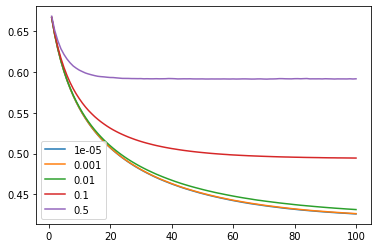

In [31]:
alpha = [0.00001, 0.001, 0.01, 0.1, 0.5]
dev_loss_count_list = list()

for a in alpha:
    print("alpha: "+str(a))
    _, _, dev_loss_count = SGD(X_tr_tfidf, train_sent_label_arr, X_dev=X_val_tfidf, Y_dev=valid_sent_label_arr, lr=0.0001, alpha=a, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count)

plt.figure()
for i in range(5):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=alpha[i])
plt.legend()

learning rate: 5e-05
learning rate: 0.0001
learning rate: 0.0005
learning rate: 0.001


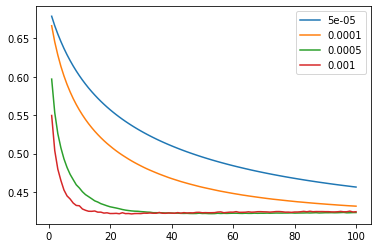

In [32]:
lr = [0.00005, 0.0001, 0.0005, 0.001]
dev_loss_count_list = list()

for l in lr:
    print("learning rate: "+str(l))
    _, _, dev_loss_count = SGD(X_tr_tfidf, train_sent_label_arr, X_dev=X_val_tfidf, Y_dev=valid_sent_label_arr, lr=l, alpha=0.01, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count)

plt.figure()
for i in range(4):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=lr[i])
plt.legend()

**Conclusion: learning rate and regularisation strength should be 0.0001 and 0.001 respectively.**

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

## task1.2.2 Plot train and valid loss:

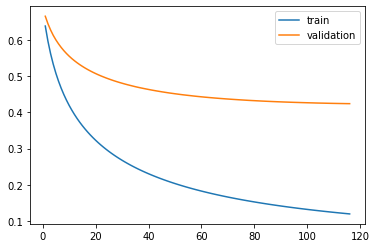

In [33]:
# fill in your code...
# loss_tr_count, dev_loss_count
epochs = [i for i in range(1, len(trl)+1)]
plt.figure()
plt.plot(epochs, trl, label="train")
plt.plot(epochs, devl, label="validation")
plt.legend()

**the model is overfitting because the train loss is far smaller than validation loss we could increase regularisation strength to improve overfitting.**

## task1.2.3 Compute accuracy, precision, recall and F1-scores:

In [34]:
# fill in your code...
preds_te = predict_class(X_te_tf, w_tfidf)
Y_te = test_sent_label_arr

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.8425
Precision: 0.9202453987730062
Recall: 0.75
F1-Score: 0.8264462809917356


## task1.2.4 Print top-10 most positive and negative words:

In [35]:
# fill in your code...
dict_vocab_w_tfidf = dict(zip(w_tfidf, vocab))
dict_vocab_w_order_tfidf = dict(sorted(dict_vocab_w_tfidf.items(), key=lambda item: item[0], reverse=True))

# positive.
print(list(dict_vocab_w_order_tfidf.values())[:10])

['great', 'truman', 'hilarious', 'perfectly', 'terrific', 'fun', 'memorable', 'overall', 'definitely', 'excellent']


In [36]:
# negative.
print(list(dict_vocab_w_order_tfidf.values())[-11:-1])

['waste', 'stupid', 'ridiculous', 'script', 'nothing', 'why', 'unfortunately', 'supposed', 'boring', 'worst']


**Similarly, we could use the model in new domain because those emotional word could be used generally in different domain such as great, fun as well as boring, worst.**

**Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?**

* tf: lr: 0.0001, alpha: 0.01.

* tf.idf: both are 0.0001.

**learning rate and regularisation strength shouldn't be too big or too small. As for learning rate, if lr is too big, the gradient descent might ignore the global minimum points. Otherwise, it needs a long training time to reach this point. Moreover, there is a relationship between epochs and lr, smaller lr might needs more training epochs. With aspect to regularisation strength, big strength could cause model underfitting. small strength could cause overfitting. we could use k fold cross validation to choose best hyperparameter.**



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.83  |  0.84 |  0.83 |
| BOW-tfidf  | 0.92  | 0.75  | 0.82  |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [37]:
# fill in your code...
train_topic = pd.read_csv("data_topic/train.csv", header=None, names=["label", "train"])
valid_topic = pd.read_csv("data_topic/dev.csv", header=None, names=["label", "valid"])
test_topic = pd.read_csv("data_topic/test.csv", header=None, names=["label", "test"])

# list, array.
train_topic_list = list(train_topic.loc[:, "train"])
train_topic_label_arr = np.array(train_topic.loc[:, "label"]).reshape(1, -1)

valid_topic_list = list(valid_topic.loc[:, "valid"])
valid_topic_label_arr = np.array(valid_topic.loc[:, "label"]).reshape(1, -1)

test_topic_list = list(test_topic.loc[:, "test"])
test_topic_label_arr = np.array(test_topic.loc[:, "label"])

In [38]:
train_topic.head()

,label,train
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [39]:
features, train_topic_df, ngram_counts = get_vocab(train_topic_list, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(train_topic_df.most_common()[:10])

5000

['talents', 'established', 'risk', ('little', 'more'), 'fresh', 'oscar', ('plot', 'twists'), 'devoted', 'front', 'fat', 'lucas', 'farm', 'cinematographer', 'fairy', 'care', 'kenobi', 'state', 'cast', 'appearance', 'parker', 'shrek', 'guessed', 'rival', 'conceived', 'bloody', 'saw', 'french', 'ramsey', ('best', 'friend'), 'lee', 'stanley', ('film', 'so'), 'fool', 'chuckle', 'forty', 'help', 'controversial', 'virtually', ('de', 'niro'), 'realism', 'opposite', ('certainly', 'not'), 'fine', 'central', 'tragic', 'spoken', 'yeah', ('each', 'other'), ('production', 'design'), 'novel', 'lead', 'philip', ('probably', 'best'), 'slowly', 'leads', 'anything', ('when', 'one'), 'act', 'alan', 'hilarious', ('if', 'anything'), 'kevin', 'due', 'elfman', ('steve', 'martin'), 'cartoonish', ('dante', 'peak'), 'pregnant', 'however', ('about', 'their'), 'spending', 'combat', 'influence', 'soul', 'angel', ('makes', 'film'), ('movie', 'will'), 'steal', 'explosions', 'bits', 'basic', 'audiences', 'nervou

In [40]:
# fill in your code...
# fill in your code...
vocab = set(features)
X_tr_tf = vectorise(train_topic_list, vocab)
X_val_tf = vectorise(valid_topic_list, vocab)
X_te_tf = vectorise(test_topic_list, vocab)

print(X_tr_tf.shape)
print(X_val_tf.shape)
print(X_te_tf.shape)

(2400, 5000)
(150, 5000)
(900, 5000)


In [41]:
# df of training set keeps same order with vocab.
train_topic_df_order = dict(zip(vocab, len(vocab)*[0]))

for i in vocab:
    train_topic_df_order[i] = train_topic_df[i]
    
print(len(train_topic_df_order))

5000


In [42]:
X_tr_df = np.array(list(train_topic_df_order.values()))
X_tr_idfs = np.log10(X_tr_tf.shape[0]/X_tr_df) 

# valid df, idfs.
X_val_df = sum(X_val_tf != 0) + 1
X_val_idfs = np.log10(X_val_tf.shape[0]/X_val_df)

# testing df, idfs.
X_te_df = sum(X_te_tf != 0) + 1
X_te_idfs = np.log10(X_te_tf.shape[0]/X_te_df) 

print(X_tr_idfs.shape)
print(X_val_idfs.shape)
print(X_te_idfs.shape)

(5000,)
(5000,)
(5000,)


In [43]:
# training tf.idf.
X_tr_tfidf = X_tr_tf*X_tr_idfs

# valid tf.idf.
X_val_tfidf = X_val_tf*X_val_idfs

# testing tf.idf.
X_te_tfidf = X_te_tf*X_te_idfs

print(X_tr_tfidf.shape)
print(X_val_tfidf.shape)
print(X_te_tfidf.shape)

(2400, 5000)
(150, 5000)
(900, 5000)


Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [44]:
def softmax(z):
    
    smax = np.exp(z) / np.exp(z).sum(axis=0)
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [45]:
# weights = (class, features).

def predict_proba(X, weights):

    preds_proba = softmax((weights @ X.T)).T
        
    return preds_proba

In [46]:
def predict_class(X, weights):
    
    # fill in your code...
    p = predict_proba(X, weights)
    preds_class = np.argmax(p, axis=1) + 1
    
    return preds_class

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [47]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    # fill in your code...
    prob = predict_proba(X, weights)
    loss = 0
    for i in range(0, prob.shape[0]):
        loss-=np.log(prob[i][Y[0, i]-1])
        
    loss = loss/X.shape[0] + alpha*np.dot(weights, weights.T).sum()
    
    return loss

Finally you need to modify SGD to support the categorical cross entropy loss:

In [48]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=30, tolerance=0, print_progress=True):
    
    # fill in your code...
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # weights and gradient of weights.
    w = np.zeros(X_tr.shape[1]*num_classes).reshape(num_classes, -1)
    
    # index of dataset for shuffle.
    X_tr_len = X_tr.shape[0]
    index = [i for i in range(X_tr_len)]
    
    for epo in range(1, epochs+1):
        # shuffle index.
        random.shuffle(index)
        for i in index:
            x_tr, y_tr = X_tr[i], Y_tr[0, i]
            predict = predict_proba(x_tr, w)
            # here for true class, we need to sub 1.
            predict[y_tr - 1] -= 1
            predict, x_tr = predict.reshape(-1, 1), x_tr.reshape(1, -1)
            gW = predict*x_tr + 2*alpha*w
            w -= lr*gW
            
        # loss.
        tr_loss = categorical_loss(X_tr, Y_tr, w, alpha)
        val_loss = categorical_loss(X_dev, Y_dev, w, alpha)
        
        training_loss_history.append(tr_loss)
        validation_loss_history.append(val_loss)
        
        if print_progress == True:
            print("Epoch: ",epo, "| Training loss: ", tr_loss,"| Validation loss: ", val_loss)
        
        if epo >= 2:
            if  (tolerance != 0) & ((validation_loss_history[-2] - validation_loss_history[-1]) <= tolerance) & (validation_loss_history[-2] > validation_loss_history[-1]):
                print("stop training.")
                break;

    return w, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

## task2.1 Train and Evaluate multi-class Logistic Regression with Count vectors:

In [49]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_tf, train_topic_label_arr, 
                                             X_dev=X_val_tf, 
                                             Y_dev=valid_topic_label_arr,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001,
                                             tolerance=0.0001,
                                             epochs=200)

Epoch:  1 | Training loss:  0.8952743928164559 | Validation loss:  0.9780940225558068
Epoch:  2 | Training loss:  0.783324942533245 | Validation loss:  0.8961715926094455
Epoch:  3 | Training loss:  0.7077824352793674 | Validation loss:  0.8348204815371797
Epoch:  4 | Training loss:  0.6522436181044833 | Validation loss:  0.7868142719152398
Epoch:  5 | Training loss:  0.6092332220430559 | Validation loss:  0.7480790513843104
Epoch:  6 | Training loss:  0.5745219013558768 | Validation loss:  0.7161242242186275
Epoch:  7 | Training loss:  0.5457161020638224 | Validation loss:  0.6891556344934799
Epoch:  8 | Training loss:  0.5213214297070522 | Validation loss:  0.6661224755738977
Epoch:  9 | Training loss:  0.5002384811688905 | Validation loss:  0.6460921436678466
Epoch:  10 | Training loss:  0.48178295828854006 | Validation loss:  0.6286006795953534
Epoch:  11 | Training loss:  0.46542109421023553 | Validation loss:  0.613079986985742
Epoch:  12 | Training loss:  0.4507800697340703 | Va

Epoch:  95 | Training loss:  0.2041491450179184 | Validation loss:  0.38797310648033945
Epoch:  96 | Training loss:  0.20343751930284015 | Validation loss:  0.38748426016882914
Epoch:  97 | Training loss:  0.20273869065130692 | Validation loss:  0.38700269059295406
Epoch:  98 | Training loss:  0.20205261148854722 | Validation loss:  0.38653825916932016
Epoch:  99 | Training loss:  0.20137977969286547 | Validation loss:  0.3861000529162139
Epoch:  100 | Training loss:  0.2007184003286161 | Validation loss:  0.38565237405589703
Epoch:  101 | Training loss:  0.20006971715947125 | Validation loss:  0.38524340441194266
Epoch:  102 | Training loss:  0.19943187132993914 | Validation loss:  0.38482681377366734
Epoch:  103 | Training loss:  0.19880631117056863 | Validation loss:  0.3844526380845061
Epoch:  104 | Training loss:  0.19819025256907408 | Validation loss:  0.3840583498895111
Epoch:  105 | Training loss:  0.19758503714746076 | Validation loss:  0.383673908418623
Epoch:  106 | Training

## task2.1.1 Hyperparameter choose:

alpha: 0.0001
alpha: 0.001
alpha: 0.01


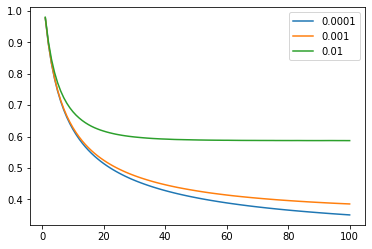

In [50]:
alpha = [0.0001, 0.001, 0.01]
dev_loss_count_list = list()

for a in alpha:
    print("alpha: "+str(a))
    _, _, dev_loss_count_1 = SGD(X_tr_tf, train_topic_label_arr,X_dev=X_val_tf, Y_dev=valid_topic_label_arr, num_classes=3, lr=0.001, alpha=a, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(3):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=alpha[i])
plt.legend()

learning rate: 0.0001
learning rate: 0.001
learning rate: 0.01


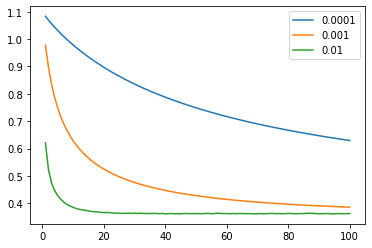

In [51]:
lr = [0.0001, 0.001, 0.01]
dev_loss_count_list = list()

for l in lr:
    print("learning rate: "+str(l))
    _, _, dev_loss_count_1 = SGD(X_tr_tf, train_topic_label_arr,X_dev=X_val_tf, Y_dev=valid_topic_label_arr, num_classes=3, lr=l, alpha=0.001, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(3):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=lr[i])
plt.legend()

**Conclusion: According to the result, learning rate and regularisation strength is 0.001 and 0.001 respectively.**

## task2.1.2 Plot train and valid loss:

Plot training and validation process and explain if your model overfit, underfit or is about right:

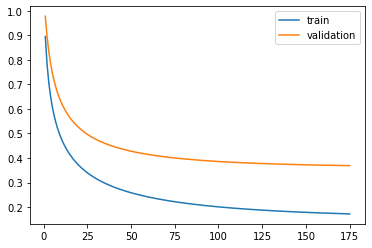

In [52]:
# fill in your code...
epochs = [i for i in range(1, len(loss_tr_count)+1)]
plt.figure()
plt.plot(epochs, loss_tr_count, label="train")
plt.plot(epochs, dev_loss_count, label="validation")
plt.legend()

**obviously, training loss is less than valid loss. this model is a little overfitting. However, valid loss and training loss have the same decreasing tendency. Therefore, we could conclude that this model is not overfitting as serious as former model.**

## task2.1.3 Compute accuracy, precision, recall and F1-scores:

In [53]:
# fill in your code...
preds_te = predict_class(X_te_tf, w_count)
Y_te = test_topic_label_arr

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8655555555555555
Precision: 0.8663904085034629
Recall: 0.8655555555555555
F1-Score: 0.8650120615156233


## task2.1.4 Top 10 features for each class:

In [54]:
# fill in your code...
for i in range(0, 3):
    dict_vocab_w_count = dict(zip(w_count[i], vocab))
    dict_vocab_w_order_count = dict(sorted(dict_vocab_w_count.items(), key=lambda item: item[0], reverse=True))
    # class 1.
    print("The ",i+1,"class: ")
    print(list(dict_vocab_w_order_count.values())[:10])

The  1 class: 
['afp', ('athens', 'greece'), 'murder', 'najaf', 'leader', 'president', 'said', 'monday', 'minister', 'troops']
The  2 class: 
['athens', 'ap', 'team', ('athens', 'reuters'), 'season', 'olympic', 'game', 'coach', 'players', 'win']
The  3 class: 
['company', 'business', 'inc', 'corp', 'market', 'oil', 'google', 'based', 'bank', 'million']


**According to the result above, the first class might about politics/goverment. the second is about sport/olympic. the third is about ecomony/ market/business. the performance of this model seems not bad and it could be used in new domain. for example, we want to classify sports between basketball and football. we could used this model to classify the documents from second class by using additional features such as named entity.**

## task2.2 tf.idf:

In [55]:
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr_tfidf, train_topic_label_arr, 
                                             X_dev=X_val_tfidf, 
                                             Y_dev=valid_topic_label_arr,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             tolerance=0.0001,
                                             epochs=300)

Epoch:  1 | Training loss:  0.6939417700216738 | Validation loss:  0.8750028573585632
Epoch:  2 | Training loss:  0.5432367680150262 | Validation loss:  0.7643652368106392
Epoch:  3 | Training loss:  0.45987342153624683 | Validation loss:  0.6957535529740575
Epoch:  4 | Training loss:  0.40519546623923874 | Validation loss:  0.6478472915317646
Epoch:  5 | Training loss:  0.3657613878048224 | Validation loss:  0.6121311524945536
Epoch:  6 | Training loss:  0.3355818900464804 | Validation loss:  0.5841390024888936
Epoch:  7 | Training loss:  0.3114480571932809 | Validation loss:  0.5614803634326953
Epoch:  8 | Training loss:  0.2915510928203865 | Validation loss:  0.5428826259972069
Epoch:  9 | Training loss:  0.27481063920387855 | Validation loss:  0.5267788557468771
Epoch:  10 | Training loss:  0.26040692334532345 | Validation loss:  0.5130758904844182
Epoch:  11 | Training loss:  0.24787665438776102 | Validation loss:  0.5012248144728174
Epoch:  12 | Training loss:  0.2368529798740626

Epoch:  96 | Training loss:  0.07887265626642624 | Validation loss:  0.34964810195980806
Epoch:  97 | Training loss:  0.07854112801881497 | Validation loss:  0.3494544688048311
Epoch:  98 | Training loss:  0.07821826785948624 | Validation loss:  0.349221227157945
Epoch:  99 | Training loss:  0.07790119073178711 | Validation loss:  0.34907020475334993
Epoch:  100 | Training loss:  0.07759215698273193 | Validation loss:  0.34885307352258554
Epoch:  101 | Training loss:  0.077287462654778 | Validation loss:  0.34870098648474057
Epoch:  102 | Training loss:  0.07699041816823665 | Validation loss:  0.34851794508910455
Epoch:  103 | Training loss:  0.07670045612554223 | Validation loss:  0.3483757164464765
Epoch:  104 | Training loss:  0.07641637121143927 | Validation loss:  0.3481890401651445
Epoch:  105 | Training loss:  0.07613644654175285 | Validation loss:  0.3480689074871249
Epoch:  106 | Training loss:  0.07586627668477593 | Validation loss:  0.3479165871482821
Epoch:  107 | Training 

## task 2.2.1 Hyperparameter choose:

alpha: 0.0001
alpha: 0.001
alpha: 0.01


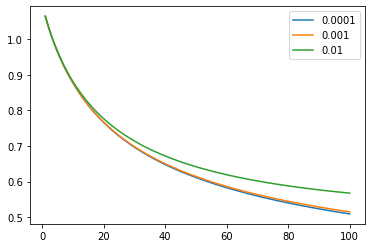

In [56]:
alpha = [0.0001, 0.001, 0.01]
dev_loss_count_list = list()

for a in alpha:
    print("alpha: "+str(a))
    _, _, dev_loss_count_1 = SGD(X_tr_tfidf, train_topic_label_arr,X_dev=X_val_tfidf, Y_dev=valid_topic_label_arr, num_classes=3, lr=0.0001, alpha=a, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(3):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=alpha[i])
plt.legend()

learning rate: 0.0001
learning rate: 0.001
learning rate: 0.01


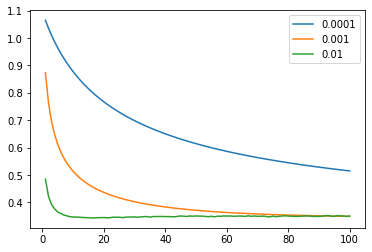

In [57]:
lr = [0.0001, 0.001, 0.01]
dev_loss_count_list = list()

for l in lr:
    print("learning rate: "+str(l))
    _, _, dev_loss_count_1 = SGD(X_tr_tfidf, train_topic_label_arr,X_dev=X_val_tfidf, Y_dev=valid_topic_label_arr, num_classes=3, lr=l, alpha=0.001, epochs=100, print_progress=False)
    dev_loss_count_list.append(dev_loss_count_1)

plt.figure()
for i in range(3):
    l = [i for i in range(1, len(dev_loss_count_list[i])+1)]
    plt.plot(l, dev_loss_count_list[i], label=alpha[i])
plt.legend()

**Conclusion: According to the figure above, learning rate and regularisation strength are both 0.001.**

## task2.2.2 Plot train and valid loss:

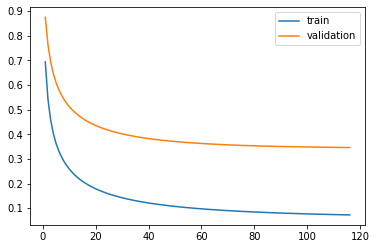

In [58]:
# fill in your code...
epochs = [i for i in range(1, len(loss_tr_tfidf)+1)]
plt.figure()
plt.plot(epochs, loss_tr_tfidf, label="train")
plt.plot(epochs, dev_loss_tfidf, label="validation")
plt.legend()

**the model is a little overfitting because training loss is less than valid loss and this difference might be increased with the increasing of epoch.**

## task2.2.3 Compute accuracy, precision, recall and F1-scores:

In [59]:
# fill in your code...
preds_te = predict_class(X_te_tfidf, w_tfidf)
Y_te = test_topic_label_arr

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8744444444444445
Precision: 0.8751265313802796
Recall: 0.8744444444444445
F1-Score: 0.8737528192226761


### task2.2.4 Top 10 features for every classes:

In [60]:
# fill in your code...
for i in range(0, 3):
    dict_vocab_w_tfidf = dict(zip(w_tfidf[i], vocab))
    dict_vocab_w_order_count = dict(sorted(dict_vocab_w_tfidf.items(), key=lambda item: item[0], reverse=True))
    # class 1.
    print("The ",i+1,"class: ")
    print(list(dict_vocab_w_order_count.values())[:10])

The  1 class: 
['afp', ('athens', 'greece'), 'beijing', 'murder', 'said', 'leader', 'najaf', 'india', 'monday', 'president']
The  2 class: 
['ap', 'athens', 'team', 'olympic', ('athens', 'reuters'), 'season', 'game', 'players', 'coach', 'games']
The  3 class: 
['company', 'business', 'market', 'oil', 'corp', 'inc', 'google', 'based', 'bank', 'sales']


**Similarly, this model using tf.idf could also perform very well and it could be used in new domain. for example, the documents about oil and agriculture could be classify based on the feature such as oil and corp in third class.**

**Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?**

* tf: both are 0.001.

* tf.idf: both are 0.001.

**As i have discussed above, bigger strength could cause underfitting. smaller strength could cause overfitting. there is a relationship between lr and training epochs. smaller epoches could increase training epoches. Otherwise, training epoches could be decreased. However, it might not reach global minimal point.**

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.87  |  0.87 |  0.87 |
| BOW-tfidf  | 0.88  | 0.88  | 0.88 |
